# Getting started with Quantum Random Access Optimization

QRAO stands for quantum random access optimization.  This tutorial assumes the `qrao` package has already been installed according to the [installation instructions](https://github.com/qiskit-community/prototype-qrao/blob/main/INSTALL.md).  By working through this tutorial, you will learn how to set up and solve a combinatorial optimization problem using `qrao`.  This prototype evolved out of research at IBM Quantum, available in the preprint [arXiv:2111.03167](https://arxiv.org/abs/2111.03167).

We begin by importing some useful things from NumPy and [Qiskit](https://qiskit.org/), including a minimum eigensolver ([VQE](https://qiskit.org/documentation/stubs/qiskit.algorithms.VQE.html)) and classical optimizer ([SPSA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html)) that we use to find an approximate solution to our problem, after it has been encoded using Quantum Random Access Codes into a quantum Hamiltonian. Check out the [background material](https://github.com/qiskit-community/prototype-qrao/blob/main/docs/background/quantum_relaxations.ipynb) for more about these encodings and the corresponding quantum Hamiltonians.

In [1]:
import numpy as np

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms.minimum_eigen_solvers import VQE
from qiskit.circuit.library import RealAmplitudes
from qiskit.algorithms.optimizers import SPSA

Next, we import
- QRAO — an approximate quantum optimizer to solve combinatorial optimization problems.
- CPLEX — an exact classical optimizer to compare with QRAO.
- a utility function to help generate random [max-cut](https://en.wikipedia.org/wiki/Maximum_cut) problems.

In [2]:
from qrao import (
    QuantumRandomAccessEncoding,  # encodes our problem into a relaxed problem that requires fewer resources to solve
    QuantumRandomAccessOptimizer,  # finds approximate solutions to the relaxed problem
    SemideterministicRounding,  # rounds the solution for the relaxed problem back to a solution of the original problem
)

from qiskit_optimization.algorithms import CplexOptimizer

from qrao.utils import get_random_maxcut_qp

## Set up a combinatorial optimization problem 

In this tutorial, we will consider a random max-cut problem instance and use QRAO to try to find a maximum cut; in other words, a partition of the graph's vertices (nodes) into two sets that maximizes the number of edges between the sets.

First, we use the [utility function](https://github.com/qiskit-community/prototype-qrao/blob/main/qrao/utils.py) `get_random_maxcut_qp` to specify the graph (degree and number of nodes) and generate a `QuadraticProgram` of the correct type. The latter is a class from `qiskit-optimization` that we use to make a model of our optimization problem. Refer to [this tutorial](https://qiskit.org/documentation/optimization/tutorials/01_quadratic_program.html) to learn how to set up a quadratic program for your own problem.

Once our problem has been represented as a `QuadraticProgram`, it will need to be converted to the correct type, a [quadratic unconstrained binary optimization (QUBO)](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization) problem, so that it is compatible with QRAO (as well as optimization algorithms from `qiskit-optimization`).

Our utility function handles all of this automatically for us, but if you define your own problem be sure you convert it to a QUBO before proceeding. Here is [a tutorial](https://qiskit.org/documentation/optimization/tutorials/02_converters_for_quadratic_programs.html) on converting `QuadraticPrograms`.

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: maxcut

Maximize
 obj: 6 x0 + 6 x1 + 6 x2 + 6 x3 + 6 x4 + 6 x5 + [ - 8 x0*x1 - 8 x0*x3 - 8 x0*x5
      - 8 x1*x2 - 8 x1*x4 - 8 x2*x3 - 8 x2*x5 - 8 x3*x4 - 8 x4*x5 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1
 0 <= x5 <= 1

Binaries
 x0 x1 x2 x3 x4 x5
End



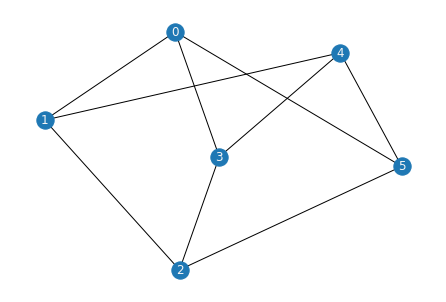

In [3]:
# Generate a random QUBO in the form of a QuadraticProgram
problem = get_random_maxcut_qp(degree=3, num_nodes=6, seed=3, draw=True)
print(problem.export_as_lp_string())

## Encode the problem into a quantum Hamiltonian

Once our problem is correctly configured, we use `QuantumRandomAccessEncoding` from the `qrao` library to generate the Hamiltonian operator that encodes our problem. In particular, we use a Quantum Random Access Code (QRAC) to encode multiple classical binary variables (nodes of our max-cut graph) into each qubit. Importantly, the "relaxed" Hamiltonian produced by this encoding will _not_ be diagonal. This is in contrast to the standard workflow in `qiskit-optimization`, which produces a diagonal (Ising) Hamiltonian that can be solved with a [`MinimumEigenOptimizer`](https://qiskit.org/documentation/optimization/tutorials/03_minimum_eigen_optimizer.html)

Here, we use a $(3,1,p)-$QRAC, which means that for a given input problem we can encode a _maximum_ of 3 classical binary variables into each qubit ($p$ represents the bit recovery probability via a measurement). Depending on the problem, some qubits may have fewer than 3 qubits assigned to them. We can check the ratio of number of original binary variables to qubits with the `compression_ratio` attribute of the encoding (which is, at best, a factor of 3).

In [4]:
# Create an encoding object with a maximum of 3 variables per qubit, aka a (3,1,p)-QRAC
encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)

# Encode the QUBO problem into an encoded Hamiltonian operator
encoding.encode(problem)

# This is our encoded operator
print(f"Our encoded Hamiltonian is:\n( {encoding.qubit_op} ).\n")
print(
    "We achieve a compression ratio of "
    f"({encoding.num_vars} binary variables : {encoding.num_qubits} qubits) "
    f"≈ {encoding.compression_ratio}.\n"
)

Our encoded Hamiltonian is:
( 2.9999999999999996 * XX
+ 2.9999999999999996 * XY
+ 2.9999999999999996 * XZ
+ 2.9999999999999996 * YX
+ 2.9999999999999996 * ZX
+ 2.9999999999999996 * YY
+ 2.9999999999999996 * YZ
+ 2.9999999999999996 * ZY
+ 2.9999999999999996 * ZZ ).

We achieve a compression ratio of (6 binary variables : 2 qubits) ≈ 3.0.



## Solve the problem using the `QuantumRandomAccessOptimizer`

Now that we have encoded our input problem as a relaxed Hamiltonian, we use the `QuantumRandomAccessOptimizer` to find an approximate solution to the relaxed problem.

To set up the optimizer, we specify a minimum eigensolver to heuristically search for the ground state of the relaxed problem Hamiltonian. Here, we use the [variational quantum eigensolver](https://qiskit.org/documentation/tutorials/algorithms/04_vqe_advanced.html) (VQE) as an example, but [QAOA](https://qiskit.org/documentation/tutorials/algorithms/05_qaoa.html) can be used as well. We'll use an Aer simulator, but a quantum device could alternatively be selected as the backend.

Additionally, we specify a rounding scheme to map the ground state results back to a solution of the original problem. Here, we use semideterministic rounding, which is also the default if left unspecified. Check out our [second tutorial on using alternative schemes](https://github.com/qiskit-community/prototype-qrao/blob/main/docs/tutorials/02_advanced_usage.ipynb) (magic rounding).

In [5]:
# Create a QuantumInstance for solving the relaxed Hamiltonian using VQE
relaxed_qi = QuantumInstance(backend=Aer.get_backend("aer_simulator"), shots=1024)

# Set up the variational quantum eigensolver (ansatz width is determined by the encoding)
vqe = VQE(
    ansatz=RealAmplitudes(encoding.num_qubits),
    optimizer=SPSA(maxiter=50),
    quantum_instance=relaxed_qi,
)

# Use semideterministic rounding, known as "Pauli rounding"
# in https://arxiv.org/pdf/2111.03167v2.pdf
# (This is the default if no rounding scheme is specified.)
rounding_scheme = SemideterministicRounding()

# Construct the optimizer
qrao = QuantumRandomAccessOptimizer(
    encoding=encoding, min_eigen_solver=vqe, rounding_scheme=rounding_scheme
)

Finally, we solve the problem. This give us access to a dictionary of results. Whether or not the problem was executed without errors is indicated by "status". Currently, if the problem executed without raising an exception, the `status` will be set to `SUCCESS`.

The "optimal value" contains the binary values of the best found solution and "optimal function value" contains the best found solution's objective value. Note that the ordering of variables in "optimal value" matches the numbering of nodes in the original graph.

It's worth clarifying that the word "optimal" is used here to be consistent with the qiskit-optimization module's naming conventions. In practice, you should interpret "optimal value" and "optimal function value" to mean the "best found" value and function value. 

The expectation value of the relaxed Hamiltonian, adjusted to be in the units of the original optimization problem, is given via the "relaxed function value". Assuming a maximization problem, the best possible relaxed function value will always be greater than or equal to the original problem's best possible function value. In practice, this will often be true of the best found value and best found function value. 

In [6]:
# Solve the optimization problem
results = qrao.solve(problem)
qrao_fval = results.fval
print(results)

QRAO Result
-----------
relaxed function value: 17.87109375
optimal function value: 18.0
optimal value: [0 1 0 1 0 1]
status: SUCCESS


Properties of the results object can be accessed directly:

In [7]:
# relaxed function value
results.relaxed_fval

17.87109375

In [8]:
# optimal function value
results.fval

18.0

In [9]:
# optimal value
results.x

array([0, 1, 0, 1, 0, 1])

In [10]:
# status
results.status

<OptimizationResultStatus.SUCCESS: 0>

### Interpret the solution

In the context of [max-cut](https://en.wikipedia.org/wiki/Maximum_cut), the result's "optimal value" tells us which subset each node belongs to given the partition found by the optimizer.

In [11]:
print(
    f"The obtained solution places a partition between nodes {np.where(results.x == 0)[0]} "
    f"and nodes {np.where(results.x == 1)[0]}."
)

The obtained solution places a partition between nodes [0 2 4] and nodes [1 3 5].


### Inspect the results of subroutines

The [`MinimumEigensolverResult`](https://qiskit.org/documentation/stubs/qiskit.algorithms.MinimumEigensolverResult.html) that results from performing VQE (or, QAOA) on the relaxed Hamiltonian is available:

In [12]:
results.relaxed_results

So too is the result of the rounding scheme. Note that in the case of semideterministic rounding used in this example, there is only a single sample that results, so it becomes the optimal solution candidate. On the other hand, using magic rounding, as shown in the [second tutorial](https://github.com/qiskit-community/prototype-qrao/blob/main/docs/tutorials/02_advanced_usage.ipynb), will result in multiple samples with probabilities that sum to one.

In [13]:
results.rounding_results.samples

[RoundingSolutionSample(x=array([0, 1, 0, 1, 0, 1]), probability=1.0)]

# Solve the problem exactly using the `CplexOptimizer`

In [14]:
cplex_optimizer = CplexOptimizer()
cplex_results = cplex_optimizer.solve(problem)
exact_fval = cplex_results.fval

cplex_results

optimal function value: 18.0
optimal value: [1. 0. 1. 0. 1. 0.]
status: SUCCESS

The approximation ratio (QRAO's approximate optimal function value divided by the exact optimal function value) tells us how closely QRAO approximated the optimal solution to the problem.

In [15]:
approximation_ratio = qrao_fval / exact_fval
print("QRAO Approximate Optimal Function Value:", qrao_fval)
print("Exact Optimal Function Value:", exact_fval)
print("Approximation Ratio: {:.2f}".format(approximation_ratio))

QRAO Approximate Optimal Function Value: 18.0
Exact Optimal Function Value: 18.0
Approximation Ratio: 1.00


## Next steps

- Copy this notebook to a new file and experiment with a different optimization problem or graph.
- Work through [the second tutorial](https://github.com/qiskit-community/prototype-qrao/blob/main/docs/tutorials/02_advanced_usage.ipynb), which uses an alternative rounding scheme known as magic rounding. This method executes on a quantum backend, which is a quantum device or a simulator.
- Return to the [documentation](https://github.com/qiskit-community/prototype-qrao/tree/main/docs), and explore the how-to guides, explanatory material, and API reference that are part of `qrao`.  We've also prepared links to other portions of the Qiskit documentation there that can help provide some background on foundational concepts, such as `VQE` and `QuadraticProgram` in Qiskit.

In [16]:
import qiskit.tools.jupyter  # pylint: disable=unused-import,wrong-import-order

%qiskit_version_table
%qiskit_copyright